First make sure pytorch and torchcvision are installed for GPU

pip install 'git+https://github.com/facebookresearch/segment-anything.git'

OR download the repo locally and install
and:  pip install -e .

Download the default trained model:
    https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth

Other models are available:
    https://github.com/facebookresearch/segment-anything#model-checkpoints



# **A. Installations**

In [ ]:
%%capture

from google.colab import drive
drive.mount('/content/drive')

# SAM
!pip install git+https://github.com/facebookresearch/segment-anything.git

# Transformers
!pip install -q git+https://github.com/huggingface/transformers.git

# Datasets to prepare data and monai if you want to use special loss functions
!pip install datasets
!pip install -q monai

# Patchify to divide large images into smaller patches for training. (Not necessary for smaller images)
!pip install patchify
!pip install nibabel

## Library Versions

In [ ]:
import torch
import torchvision

!python --version
print("PyTorch", torch.__version__)
print("Torchvision", torchvision.__version__)
print("CUDA Availabity:", torch.cuda.is_available())

import tensorflow as tf
# Check the GPU details
gpu_info = tf.config.experimental.list_physical_devices('GPU')
print(gpu_info)

import numpy as np
import torch
import matplotlib.pyplot as plt
import cv2

import sys
sys.path.append("..")
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator, SamPredictor

Python 3.10.12
PyTorch 2.5.0+cu121
Torchvision 0.20.0+cu121
CUDA Availabity: True
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


# **1. Load Test Dataset**

In [ ]:
import os
import pickle
from datasets import Dataset, concatenate_datasets
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

# Define the folder path where your .pkl files are stored
folder_path = '/content/drive/MyDrive/COMP700/EfficientSAM/'

# List only .pkl files that end with "test_dataset.pkl" in the folder
pkl_files = [os.path.join(folder_path, file) for file in os.listdir(folder_path) if file.endswith('test_dataset.pkl')]

# Initialize an empty list to store datasets
datasets = []

# Loop through each .pkl file and load the dataset
for pkl_file in pkl_files:
    dataset_name = os.path.basename(pkl_file)  # Extract the dataset name
    print(f"Loading Test Dataset: {dataset_name}")
    with open(pkl_file, 'rb') as f:
        dataset_dict = pickle.load(f)
        dataset = Dataset.from_dict(dataset_dict)
        datasets.append(dataset)

# Combine all test datasets into one (if there's more than one)
if len(datasets) > 1:
    combined_test_dataset = concatenate_datasets(datasets)
else:
    combined_test_dataset = datasets[0]  # Use the single dataset if only one


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Loading Test Dataset: retina_test_dataset.pkl
Loading Test Dataset: physionet_test_dataset.pkl
Loading Test Dataset: monuseg_test_dataset.pkl
Loading Test Dataset: busi_test_dataset.pkl
Loading Test Dataset: cvc_clinic_test_dataset.pkl
Loading Test Dataset: liverseg_test_dataset.pkl
Loading Test Dataset: refuge_test_dataset.pkl
Loading Test Dataset: abdominal_organseg_test_dataset.pkl
Loading Test Dataset: promise_test_dataset.pkl
Loading Test Dataset: isic_test_dataset.pkl
Loading Test Dataset: montgomery_chest_test_dataset.pkl


## 1.1. Use Entire Test Dataset

In [ ]:
import os
import numpy as np
import cv2

# Directory to store the converted .jpg images
image_save_dir = "/content/test_images"
mask_save_dir = "/content/test_masks"
os.makedirs(image_save_dir, exist_ok=True)
os.makedirs(mask_save_dir, exist_ok=True)

# Save images and masks as .jpg files
for i, sample in enumerate(combined_test_dataset):
    image = np.array(sample["image"])
    mask = np.array(sample["label"])

    # Check the shape of the image
    if image.ndim == 3:  # If the image has a shape like (channels, height, width)
        image = image.transpose(1, 2, 0)  # Change to (height, width, channels)

    # Convert and save image and mask as .jpg
    image_path = os.path.join(image_save_dir, f"image_{i}.jpg")
    mask_path = os.path.join(mask_save_dir, f"mask_{i}.jpg")

    # Ensure mask is binary (0-255)
    mask_binary = (mask * 255).astype(np.uint8)  # Convert mask to binary format (0 or 255)

    # Save image and mask
    cv2.imwrite(image_path, cv2.cvtColor(image, cv2.COLOR_RGB2BGR))
    cv2.imwrite(mask_path, mask_binary)  # Ensure binary mask is saved correctly

print("All images and masks saved as .jpg")


All images and masks saved as .jpg


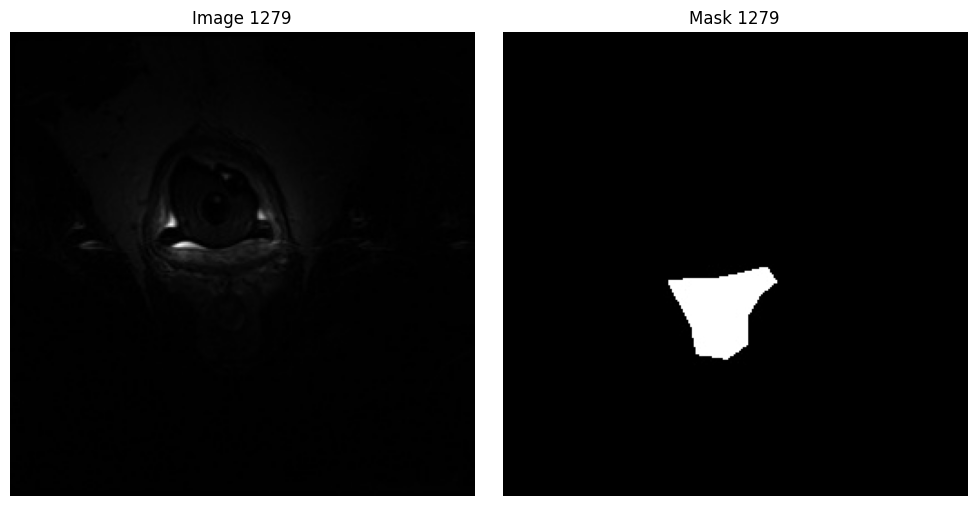

Displayed: image_887.jpg (Image 1279)
Displayed: mask_887.jpg (Mask 1279)


In [ ]:
import os
import random
import cv2
import matplotlib.pyplot as plt

# Define the directories where images and masks are saved
image_save_dir = '/content/test_images'
mask_save_dir = '/content/test_masks'

# List all image and mask files
image_files = sorted([f for f in os.listdir(image_save_dir) if f.endswith('.jpg')])
mask_files = sorted([f for f in os.listdir(mask_save_dir) if f.endswith('.jpg')])

# Ensure that the number of images and masks are the same
if len(image_files) != len(mask_files):
    raise ValueError("The number of images and masks do not match.")

# Select a random index
random_index = random.randint(0, len(image_files) - 1)

# Load the selected image and mask
image_path = os.path.join(image_save_dir, image_files[random_index])
mask_path = os.path.join(mask_save_dir, mask_files[random_index])

image = cv2.imread(image_path)
mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)  # Load mask as grayscale

# Convert BGR (OpenCV format) to RGB for displaying
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Display the image and the mask
plt.figure(figsize=(10, 5))

# Display the image
plt.subplot(1, 2, 1)
plt.imshow(image_rgb)
plt.title(f"Image {random_index + 1}")  # Image index (1-based)
plt.axis('off')

# Display the mask
plt.subplot(1, 2, 2)
plt.imshow(mask, cmap='gray')
plt.title(f"Mask {random_index + 1}")  # Mask index (1-based)
plt.axis('off')

plt.tight_layout()
plt.show()

# Print image and mask file names
print(f"Displayed: {image_files[random_index]} (Image {random_index + 1})")
print(f"Displayed: {mask_files[random_index]} (Mask {random_index + 1})")


### Use Random Image from Dataset

Using image at index: 173


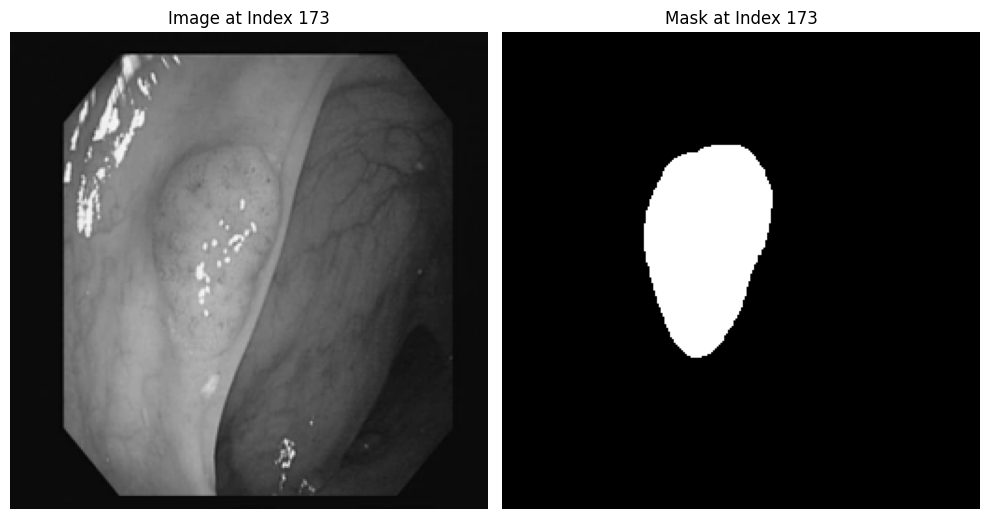

In [ ]:
from PIL import Image
import numpy as np
from io import BytesIO
from IPython.display import display
import matplotlib.pyplot as plt
import random

# Select a random image from the dataset
random_index = random.randint(0, len(combined_test_dataset) - 1)
print(f"Using image at index: {random_index}")
random_item = combined_test_dataset[random_index]

# Assuming the image is stored as a NumPy array in the 'image' field
image_array = np.array(random_item['image'])  # Adjust field name if needed
mask_array = np.array(random_item['label'])

# Convert the image to OpenCV's BGR format (if needed)
if image_array.shape[-1] == 3:  # Check if it's an RGB image
    image_bgr = cv2.cvtColor(image_array, cv2.COLOR_RGB2BGR)
else:
    image_bgr = image_array  # Assume grayscale if not 3-channel

# Display the image and mask using matplotlib
plt.figure(figsize=(10, 10))

# Display the image
plt.subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB))  # Convert back to RGB for display
plt.title(f"Image at Index {random_index}")
plt.axis('off')

# Display the mask
plt.subplot(1, 2, 2)
plt.imshow(mask_array, cmap='gray')  # Display mask in grayscale
plt.title(f"Mask at Index {random_index}")
plt.axis('off')

plt.tight_layout()
plt.show()

In [ ]:
# Iterate through all items in the combined_test_dataset
for index, item in enumerate(combined_test_dataset):
    # Assuming the image is stored as a NumPy array in the 'image' field
    image_array = np.array(item['image'])  # Adjust field name if needed

    # Convert the image to OpenCV's BGR format (if needed)
    if image_array.shape[-1] == 3:  # Check if it's an RGB image
        image_bgr = cv2.cvtColor(image_array, cv2.COLOR_RGB2BGR)
    else:
        image_bgr = image_array  # Assume grayscale if not 3-channel


## 1.2. Use Dataset per Modality

In [ ]:
import os
import pickle
import numpy as np
import cv2
from datasets import Dataset, concatenate_datasets
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

# Define folder path where your .pkl files are stored
folder_path = '/content/drive/MyDrive/COMP700/EfficientSAM/'

# List only .pkl files that end with "test_dataset.pkl"
pkl_files = [os.path.join(folder_path, file) for file in os.listdir(folder_path)
             if file.endswith('test_dataset.pkl')]

# Dictionary mapping datasets to their corresponding modality
datasets_modalities = {
    "kvasir_test_dataset": "Endoscopy",
    "cvc_clinic_test_dataset": "Colonoscopy",
    "busi_test_dataset": "Ultrasound",
    "monuseg_test_dataset": "Endoscopy",
    "physionet_test_dataset": "Cardiac",
    "retina_test_dataset": "Fundus",
    "liverseg_test_dataset": "CT",
    "abdominal_organseg_test_dataset": "CT",
    "promise_test_dataset": "MRI",
    "isic_test_dataset": "Dermoscopy",
    "montgomery_chest_test_dataset": "X-ray",
    "refuge_test_dataset": "Fundus"
}

# Initialize a dictionary to store modality-specific datasets
modality_datasets = {modality: [] for modality in set(datasets_modalities.values())}

# Load each test dataset and assign it to the appropriate modality
for pkl_file in pkl_files:
    dataset_name = os.path.basename(pkl_file).replace('_test_dataset.pkl', '')
    modality = datasets_modalities.get(f"{dataset_name}_test_dataset", "Unknown")

    print(f"Loading {dataset_name} (Modality: {modality})")

    with open(pkl_file, 'rb') as f:
        dataset_dict = pickle.load(f)
        dataset = Dataset.from_dict(dataset_dict)

    if modality != "Unknown":
        modality_datasets[modality].append(dataset)
    else:
        print(f"Warning: {dataset_name} does not have a known modality.")

# Create modality-specific folders and save images/masks
base_image_dir = "/content/modality_images"
base_mask_dir = "/content/modality_masks"

os.makedirs(base_image_dir, exist_ok=True)
os.makedirs(base_mask_dir, exist_ok=True)

for modality, datasets in modality_datasets.items():
    if not datasets:
        continue

    combined_dataset = concatenate_datasets(datasets) if len(datasets) > 1 else datasets[0]

    modality_image_dir = os.path.join(base_image_dir, modality)
    modality_mask_dir = os.path.join(base_mask_dir, modality)

    os.makedirs(modality_image_dir, exist_ok=True)
    os.makedirs(modality_mask_dir, exist_ok=True)

    for i, sample in enumerate(combined_dataset):
        image = np.array(sample["image"])
        mask = np.array(sample["label"])

        if image.ndim == 3:
            image = image.transpose(1, 2, 0)

        mask_binary = (mask * 255).astype(np.uint8)

        image_path = os.path.join(modality_image_dir, f"image_{i}.jpg")
        mask_path = os.path.join(modality_mask_dir, f"mask_{i}.jpg")

        cv2.imwrite(image_path, cv2.cvtColor(image, cv2.COLOR_RGB2BGR))
        cv2.imwrite(mask_path, mask_binary)

    print(f"Saved {len(combined_dataset)} samples for modality: {modality}")

print("All modality-specific images and masks have been saved.")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Loading retina (Modality: Fundus)
Loading physionet (Modality: Cardiac)
Loading monuseg (Modality: Endoscopy)
Loading busi (Modality: Ultrasound)
Loading cvc_clinic (Modality: Colonoscopy)
Loading liverseg (Modality: CT)
Loading refuge (Modality: Fundus)
Loading abdominal_organseg (Modality: CT)
Loading promise (Modality: MRI)
Loading isic (Modality: Dermoscopy)
Loading montgomery_chest (Modality: X-ray)
Saved 14 samples for modality: X-ray
Saved 32 samples for modality: Cardiac
Saved 61 samples for modality: Colonoscopy
Saved 418 samples for modality: MRI
Saved 65 samples for modality: Ultrasound
Saved 260 samples for modality: Dermoscopy
Saved 119 samples for modality: CT
Saved 420 samples for modality: Fundus
Saved 14 samples for modality: Endoscopy
All modality-specific images and masks have been saved.


# **2. Build SAM using the existing ViT Architecture**



In [ ]:
#sam_checkpoint = "/content/drive/MyDrive/COMP700/sam_vit_h_4b8939.pth"
sam_checkpoint = "/content/drive/MyDrive/COMP700/sam_vit_b_01ec64.pth"
#sam_checkpoint = "/content/drive/MyDrive/COMP700/sam_vit_l_0b3195.pth"
model_type = "vit_b"
device = "cuda"

sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device=device)

#There are several tunable parameters in automatic mask generation that control
# how densely points are sampled and what the thresholds are for removing low
# quality or duplicate masks. Additionally, generation can be automatically
# run on crops of the image to get improved performance on smaller objects,
# and post-processing can remove stray pixels and holes.
# Here is an example configuration that samples more masks:
#https://github.com/facebookresearch/segment-anything/blob/9e1eb9fdbc4bca4cd0d948b8ae7fe505d9f4ebc7/segment_anything/automatic_mask_generator.py#L35


/usr/local/lib/python3.10/dist-packages/segment_anything/build_sam.py:105: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(f)


Sam(
  (image_encoder): ImageEncoderViT(
    (patch_embed): PatchEmbed(
      (proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
    )
    (blocks): ModuleList(
      (0-11): 12 x Block(
        (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (attn): Attention(
          (qkv): Linear(in_features=768, out_features=2304, bias=True)
          (proj): Linear(in_features=768, out_features=768, bias=True)
        )
        (norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (mlp): MLPBlock(
          (lin1): Linear(in_features=768, out_features=3072, bias=True)
          (lin2): Linear(in_features=3072, out_features=768, bias=True)
          (act): GELU(approximate='none')
        )
      )
    )
    (neck): Sequential(
      (0): Conv2d(768, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (1): LayerNorm2d()
      (2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (3): LayerNorm2d()
    )


# **3. Update SAM using the EfficientSAM Architecture and Weights**

In [ ]:
import torch
from segment_anything import sam_model_registry

# Path to the original SAM model checkpoint
sam_checkpoint = "/content/drive/MyDrive/COMP700/sam_vit_b_01ec64.pth"
model_type = "vit_b"
device = "cuda"

# Load the original SAM model
sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device=device)

# Path to the fine-tuned checkpoint
checkpoint_path = "/content/drive/MyDrive/COMP700/EfficientSAM/SAM_Checkpoints/model_epoch_11.pth"

# Load the fine-tuned weights
fine_tuned_weights = torch.load(checkpoint_path)

# Update the SAM model's state_dict with the fine-tuned weights
sam.load_state_dict(fine_tuned_weights["model_state_dict"], strict=False)

print("Loaded fine-tuned SAM checkpoint successfully.")



/usr/local/lib/python3.10/dist-packages/segment_anything/build_sam.py:105: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(f)
<ipython-input-50-dbe2ab6

Loaded fine-tuned SAM checkpoint successfully.


# **Image and Mask Properties**

## Compute Predictions on all Images

In [ ]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.distance import directed_hausdorff

# Function to calculate IoU
def calculate_iou(pred_mask, true_mask):
    intersection = np.logical_and(pred_mask, true_mask)
    union = np.logical_or(pred_mask, true_mask)
    return np.sum(intersection) / np.sum(union) if np.sum(union) > 0 else 0

# Function to calculate Dice score
def calculate_dice(pred_mask, true_mask):
    intersection = np.logical_and(pred_mask, true_mask)
    return 2 * np.sum(intersection) / (np.sum(pred_mask) + np.sum(true_mask)) if (np.sum(pred_mask) + np.sum(true_mask)) > 0 else 0

# Function to calculate Hausdorff Distance
def calculate_hausdorff(pred_mask, true_mask):
    pred_coords = np.argwhere(pred_mask)
    true_coords = np.argwhere(true_mask)
    if len(pred_coords) == 0 or len(true_coords) == 0:
        return float('inf')  # Return infinity if there's no prediction or truth

    d1 = directed_hausdorff(pred_coords, true_coords)[0]
    d2 = directed_hausdorff(true_coords, pred_coords)[0]
    return max(d1, d2)

# Initialize the mask generator
mask_generator_ = SamAutomaticMaskGenerator(
    model=sam,
    points_per_side=32,
    pred_iou_thresh=0.9,
    stability_score_thresh=0.96,
    crop_n_layers=1,
    crop_n_points_downscale_factor=2,
    min_mask_region_area=100,  # Requires open-cv to run post-processing
)

# Directory where the images are saved
image_save_dir = "/content/modality_images/Fundus"
mask_save_dir = "/content/modality_masks/Fundus"
image_files = sorted([f for f in os.listdir(image_save_dir) if f.endswith('.jpg')])

# Initialize lists to store scores
ious = []
dice_scores = []
hausdorff_distances = []

# Process the images
for index, image_file in enumerate(image_files):
    image_path = os.path.join(image_save_dir, image_file)
    mask_path = os.path.join(mask_save_dir, f"mask_{index}.jpg")  # Assuming mask filenames match

    image_bgr = cv2.imread(image_path)  # Read image in BGR format
    if image_bgr is None:
        print(f"Error reading {image_file}. Skipping...")
        continue

    # Generate masks for the current image
    masks = mask_generator_.generate(image_bgr)

    # Load the true mask (assuming the masks are in binary format)
    true_mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
    true_mask = (true_mask > 0).astype(np.uint8)  # Convert to binary mask

    # Calculate metrics for each generated mask
    for mask in masks:
        pred_mask = mask['segmentation']

        iou = calculate_iou(pred_mask, true_mask)
        dice = calculate_dice(pred_mask, true_mask)
        hausdorff = calculate_hausdorff(pred_mask, true_mask)

        ious.append(iou)
        dice_scores.append(dice)
        hausdorff_distances.append(hausdorff)

        print(f"Processed {image_file}: IoU={iou:.4f}, Dice={dice:.4f}, Hausdorff Distance={hausdorff:.4f}")

# Calculate average scores
average_iou = np.mean(ious)
average_dice = np.mean(dice_scores)
average_hausdorff = np.mean(hausdorff_distances)

# Print average scores
print(f"Average IoU: {average_iou:.4f}")
print(f"Average Dice Score: {average_dice:.4f}")
print(f"Average Hausdorff Distance: {average_hausdorff:.4f}")




Processed image_0.jpg: IoU=0.0060, Dice=0.0119, Hausdorff Distance=204.1201
Processed image_0.jpg: IoU=0.0191, Dice=0.0374, Hausdorff Distance=188.3109
Processed image_0.jpg: IoU=0.0066, Dice=0.0130, Hausdorff Distance=210.2023
Processed image_0.jpg: IoU=0.1562, Dice=0.2701, Hausdorff Distance=37.1214
Processed image_1.jpg: IoU=0.1860, Dice=0.3137, Hausdorff Distance=29.0172
Processed image_1.jpg: IoU=0.0092, Dice=0.0182, Hausdorff Distance=181.6480
Processed image_10.jpg: IoU=0.0000, Dice=0.0000, Hausdorff Distance=221.6236
Processed image_10.jpg: IoU=0.0051, Dice=0.0101, Hausdorff Distance=198.6555
Processed image_10.jpg: IoU=0.0000, Dice=0.0000, Hausdorff Distance=197.9419
Processed image_10.jpg: IoU=0.1372, Dice=0.2413, Hausdorff Distance=59.4643
Processed image_100.jpg: IoU=0.0115, Dice=0.0228, Hausdorff Distance=190.6017
Processed image_100.jpg: IoU=0.1297, Dice=0.2297, Hausdorff Distance=60.9016
Processed image_100.jpg: IoU=0.0000, Dice=0.0000, Hausdorff Distance=129.5415
Proces

In [ ]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Initialize the mask generator
mask_generator_ = SamAutomaticMaskGenerator(
    model=sam,
    points_per_side=32,
    pred_iou_thresh=0.9,
    stability_score_thresh=0.96,
    crop_n_layers=1,
    crop_n_points_downscale_factor=2,
    min_mask_region_area=100,  # Requires open-cv to run post-processing
)

# Directory where the images are saved
image_save_dir = "/content/test_images"
image_files = sorted([f for f in os.listdir(image_save_dir) if f.endswith('.jpg')])

# List to store all masks
all_masks = []

# Process each image
for image_file in image_files:
    image_path = os.path.join(image_save_dir, image_file)
    image_bgr = cv2.imread(image_path)  # Read image in BGR format
    if image_bgr is None:
        print(f"Error reading {image_file}. Skipping...")
        continue

    # Generate masks for the current image
    masks = mask_generator_.generate(image_bgr)
    all_masks.append(masks)

    print(f"Processed {image_file}: {len(masks)} masks generated.")

# Function to show annotations
def show_anns(anns):
    if len(anns) == 0:
        return
    sorted_anns = sorted(anns, key=(lambda x: x['area']), reverse=True)
    ax = plt.gca()
    ax.set_autoscale_on(False)
    polygons = []
    color = []
    for ann in sorted_anns:
        m = ann['segmentation']
        img = np.ones((m.shape[0], m.shape[1], 3))
        color_mask = np.random.random((1, 3)).tolist()[0]
        for i in range(3):
            img[:, :, i] = color_mask[i]
        ax.imshow(np.dstack((img, m * 0.35)))

# Example: Display masks for the first processed image
if all_masks:
    plt.figure(figsize=(10, 10))
    show_anns(all_masks[0])  # Show masks for the first image
    plt.title(f"Masks for {image_files[0]}")
    plt.axis('off')
    plt.show()
else:
    print("No masks generated.")


Processed image_0.jpg: 4 masks generated.
Processed image_1.jpg: 2 masks generated.
Processed image_10.jpg: 4 masks generated.
Processed image_100.jpg: 32 masks generated.
Processed image_1000.jpg: 25 masks generated.
Processed image_1001.jpg: 25 masks generated.
Processed image_1002.jpg: 28 masks generated.
Processed image_1003.jpg: 25 masks generated.
Processed image_1004.jpg: 27 masks generated.
Processed image_1005.jpg: 25 masks generated.
Processed image_1006.jpg: 32 masks generated.
Processed image_1007.jpg: 26 masks generated.
Processed image_1008.jpg: 30 masks generated.
Processed image_1009.jpg: 30 masks generated.
Processed image_101.jpg: 73 masks generated.
Processed image_1010.jpg: 30 masks generated.
Processed image_1011.jpg: 33 masks generated.
Processed image_1012.jpg: 33 masks generated.
Processed image_1013.jpg: 33 masks generated.
Processed image_1014.jpg: 35 masks generated.
Processed image_1015.jpg: 29 masks generated.
Processed image_1016.jpg: 25 masks generated.
P

KeyboardInterrupt: 

## Compute Prediction on a Single Image

In [ ]:
image_bgr = cv2.imread("/content/test_images/image_164.jpg")
print(image_bgr.shape)


if len(image_bgr.shape) == 2:  # Grayscale image
    image_bgr = cv2.cvtColor(image_bgr, cv2.COLOR_GRAY2BGR)  # Convert to BGR

print(image_bgr.shape)

(256, 256, 3)
(256, 256, 3)


In [ ]:
mask_generator_ = SamAutomaticMaskGenerator(
    model=sam,
    points_per_side=32,
    pred_iou_thresh=0.9,
    stability_score_thresh=0.96,
    crop_n_layers=1,
    crop_n_points_downscale_factor=2,
    min_mask_region_area=100,  # Requires open-cv to run post-processing
)

masks = mask_generator_.generate(image_bgr)

print(len(masks))

15


# **Show Annotations from the model**

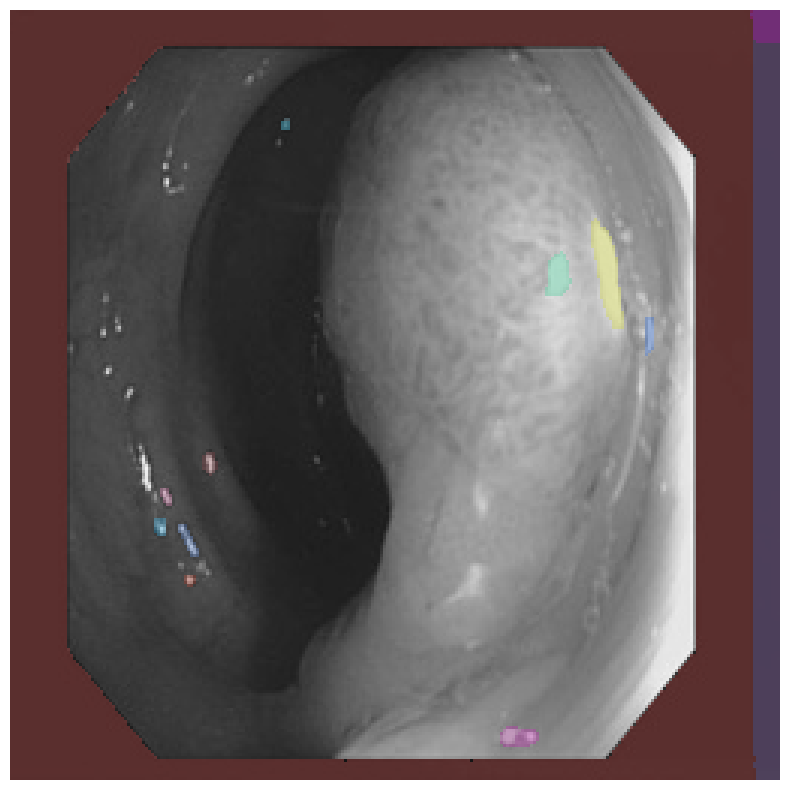

"\nMask generation returns a list over masks, where each mask is a dictionary containing various data about the mask. These keys are:\n\nsegmentation : the mask\narea : the area of the mask in pixels\nbbox : the boundary box of the mask in XYWH format\npredicted_iou : the model's own prediction for the quality of the mask\npoint_coords : the sampled input point that generated this mask\nstability_score : an additional measure of mask quality\ncrop_box : the crop of the image used to generate this mask in XYWH format\n"

In [ ]:
#Rerun the following with a few settings, ex. 0.86 & 0.9 for iou_thresh
# and 0.92 and 0.96 for score_thresh



def show_anns(anns):
    if len(anns) == 0:
        return
    sorted_anns = sorted(anns, key=(lambda x: x['area']), reverse=True)
    ax = plt.gca()
    ax.set_autoscale_on(False)
    polygons = []
    color = []
    for ann in sorted_anns:
        m = ann['segmentation']
        img = np.ones((m.shape[0], m.shape[1], 3))
        color_mask = np.random.random((1, 3)).tolist()[0]
        for i in range(3):
            img[:,:,i] = color_mask[i]
        ax.imshow(np.dstack((img, m*0.35)))


plt.figure(figsize=(10,10))
plt.imshow(image_bgr)
show_anns(masks)
plt.axis('off')
plt.show()

"""
Mask generation returns a list over masks, where each mask is a dictionary containing various data about the mask. These keys are:

segmentation : the mask
area : the area of the mask in pixels
bbox : the boundary box of the mask in XYWH format
predicted_iou : the model's own prediction for the quality of the mask
point_coords : the sampled input point that generated this mask
stability_score : an additional measure of mask quality
crop_box : the crop of the image used to generate this mask in XYWH format
"""